🔍 Loaded 478,324 rows from raw_cc_transactions.csv
🧹 Dropped 64,997 rows with missing data
✅ Wrote 413,327 rows to: SYNTH_PCA_DATA.csv


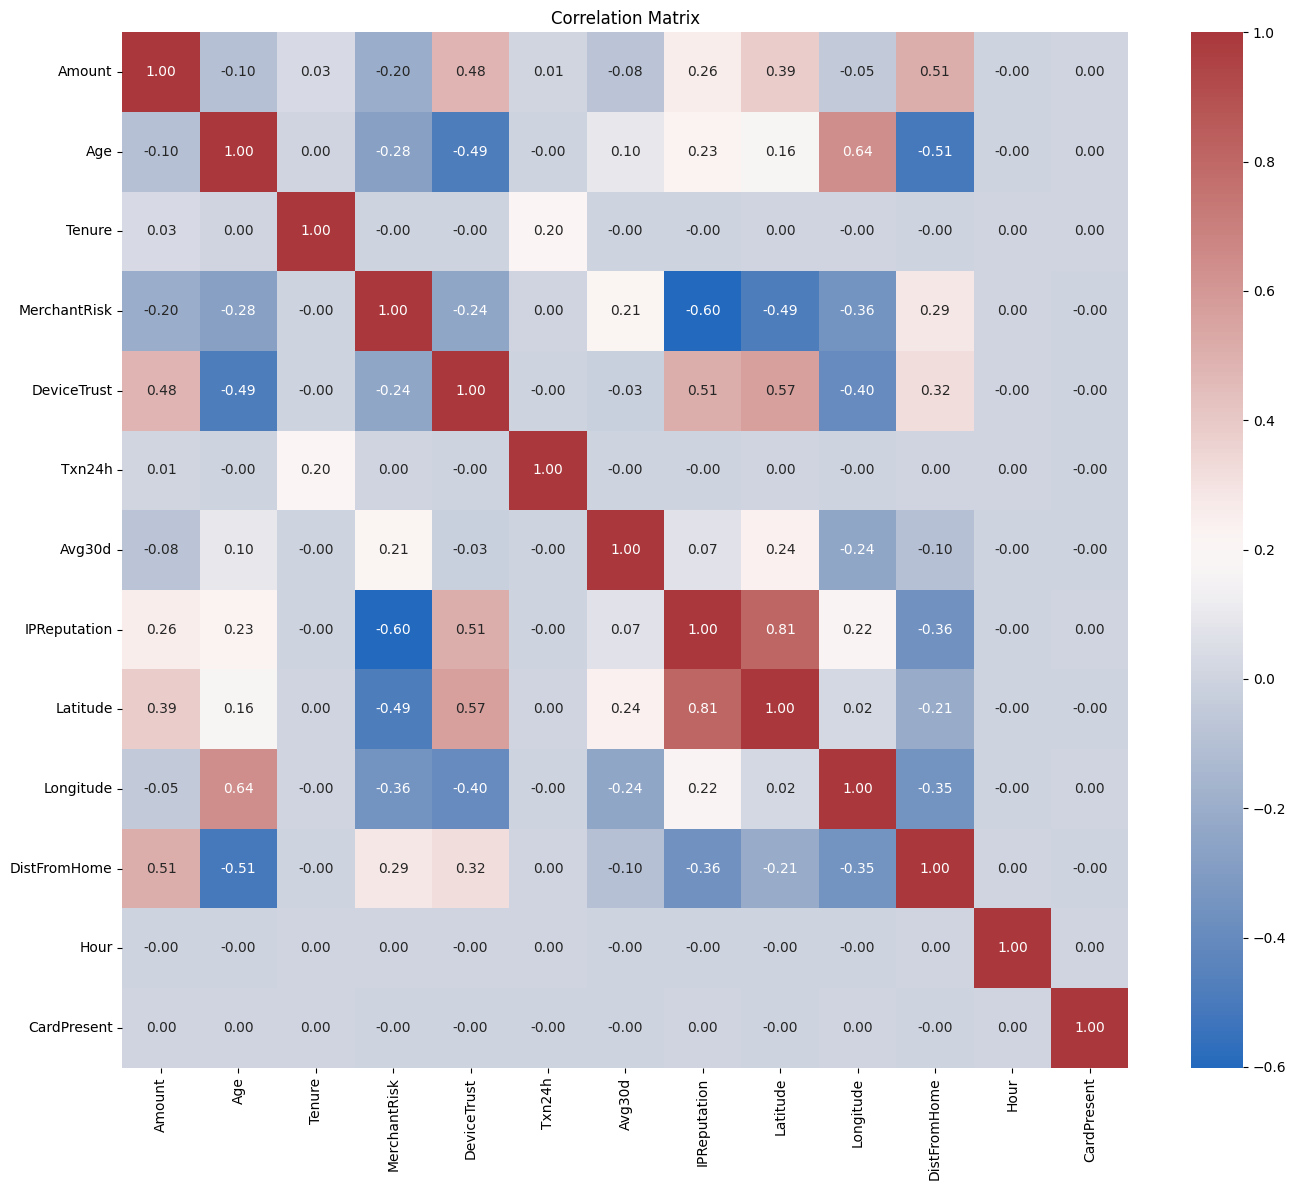

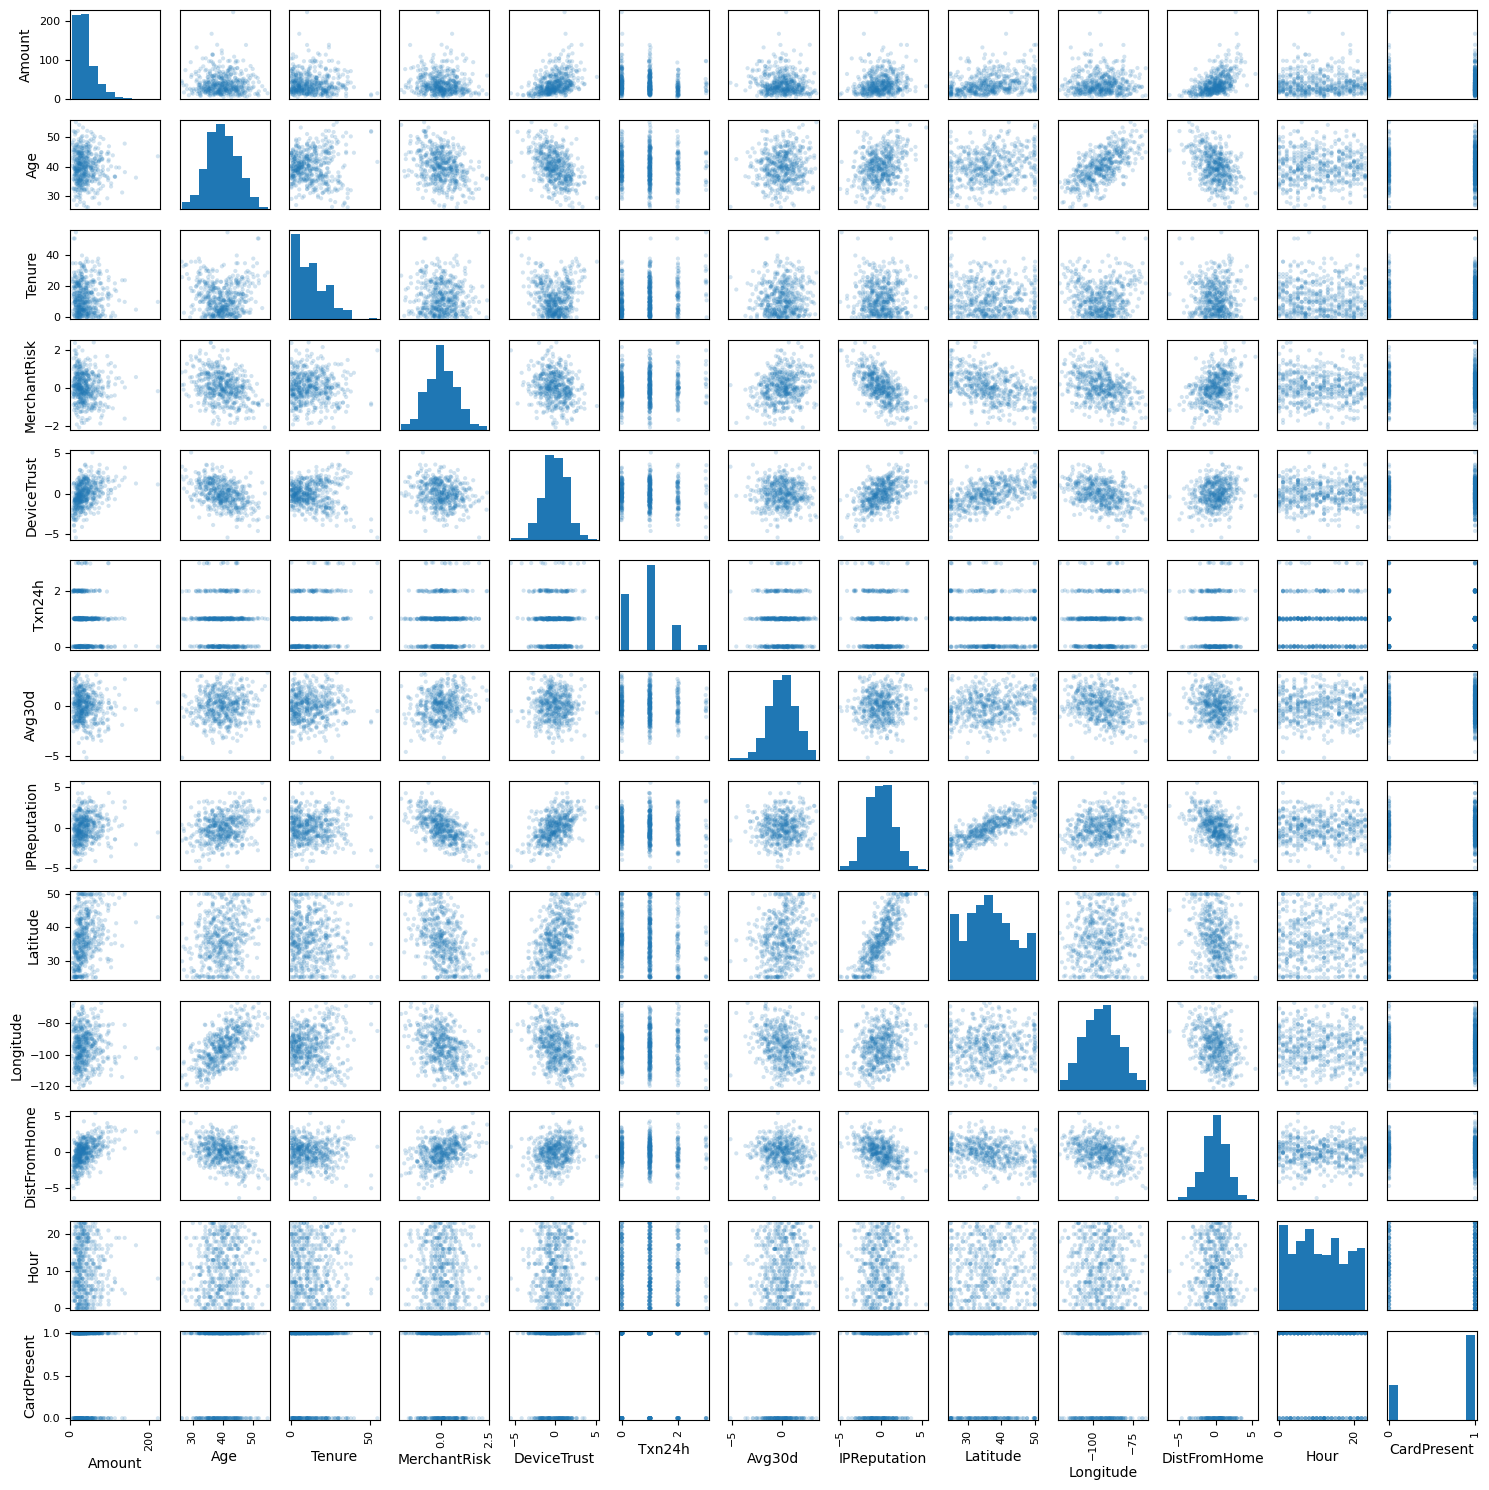

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 19/19 [00:02<00:00,  7.90it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

2025/06/18 17:58:33 INFO mlflow.pyfunc: Validating input example against model signature


saved html artifact to /mnt/artifacts/eda_report.html


2025/06/18 17:58:37 INFO mlflow.pyfunc: Validating input example against model signature


🏃 View run PCA Pipeline at: http://127.0.0.1:8768/#/experiments/1532/runs/04721d488d7c42c4a7229a64a625e00f
🧪 View experiment at: http://127.0.0.1:8768/#/experiments/1532


NameError: name '__file__' is not defined

In [11]:
# Data Ingestion, Processing, and MLflow Model Logging
import io, os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import mlflow
from mlflow.models import infer_signature

from domino.data_sources import DataSourceClient
from domino_data.datasets import DatasetClient

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from ydata_profiling import ProfileReport

import mlflow.pyfunc

%matplotlib inline

domino_working_dir = os.environ.get("DOMINO_WORKING_DIR", ".")
domino_datasource_dir = domino_working_dir.replace('code', 'data')
domino_artifact_dir = domino_working_dir.replace('code', 'artifacts')
domino_project_name = os.environ.get("DOMINO_PROJECT_NAME", "my-local-project")

## Custom PythonModel Wrappers for MLflow


class SklearnTransformerWrapper(mlflow.pyfunc.PythonModel):
    def __init__(self, transformer):
        self.transformer = transformer

    def predict(self, model_input: pd.DataFrame) -> np.ndarray:
        return self.transformer.transform(model_input)

## Data Ingestion and Processing Function
def run_data_ingestion_and_processing(raw_filename: str, pca_filename: str, n_components: int = 28):
    # 1) Download your synthetic raw file
    ds = DataSourceClient().get_datasource("credit_card_fraud_detection")
    buf = io.BytesIO()
    ds.download_fileobj(raw_filename, buf)
    buf.seek(0)
    
    df = pd.read_csv(buf)
    print(f"🔍 Loaded {len(df):,} rows from {raw_filename}")
    
    # 2) Optionally drop any rows with missing values
    before = len(df)
    df = df.dropna()
    print(f"🧹 Dropped {before - len(df):,} rows with missing data")
    
    # 3) One-hot the categorical features
    cat_cols = ["TxType", "DeviceType", "MerchantCat", "Channel"]
    ohe = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
    cat_mat = ohe.fit_transform(df[cat_cols])
    cat_names = ohe.get_feature_names_out(cat_cols)
    
    # 4) Build full feature matrix (numeric + OHE)
    num = df.drop(columns=cat_cols + ["Class"])
    features = pd.concat([
        num.reset_index(drop=True),
        pd.DataFrame(cat_mat, columns=cat_names)
    ], axis=1)
    
    mlflow.set_experiment('CC Fraud PCA Training')

    import joblib

    with mlflow.start_run(run_name="PCA Pipeline") as run:
        # Log parameters
        mlflow.log_param("n_components", n_components)
        mlflow.log_param("raw_filename", raw_filename)
        mlflow.log_param("pca_filename", pca_filename)
        mlflow.log_param("num_rows_loaded", before)
        mlflow.log_param("num_rows_after_dropna", len(df))
        mlflow.log_param("num_features_before_ohe", num.shape[1])
        mlflow.log_param("num_cat_features", len(cat_cols))
        mlflow.log_param("num_features_after_ohe", features.shape[1])
        mlflow.log_param("project_name", domino_project_name)

        # 5) Scale and PCA
        scaler = StandardScaler()
        Xs = scaler.fit_transform(features)
        pca = PCA(n_components=n_components, random_state=0)
        PCs = pca.fit_transform(Xs)
        
        # Prepare input_example and signature for model logging
        numeric_features = features.select_dtypes(include=[np.number]).copy()
        
        # Convert all integer columns to float64 to avoid MLflow schema warning
        for col in numeric_features.select_dtypes(include=["int", "int32", "int64"]).columns:
            numeric_features[col] = numeric_features[col].astype("float64")
        input_example = numeric_features.iloc[:5]
        scaler_signature = infer_signature(numeric_features, scaler.transform(numeric_features))
        pca_signature = infer_signature(scaler.transform(numeric_features), pca.transform(scaler.transform(numeric_features)))

        # 6) Re-assemble output
        pca_df = pd.DataFrame(PCs, columns=[f"V{i+1}" for i in range(n_components)])
        # preserve the key columns
        pca_df["Time"]   = df["Time"].astype(int)
        pca_df["Amount"] = df["Amount"]
        pca_df["Class"]  = df["Class"].astype(int)
        
        # 7) Save Dataset
        full_data_path = f"{domino_datasource_dir}/{domino_project_name}"
        pca_csv_path = f"{full_data_path}/{pca_filename}"
        pca_df.to_csv(pca_csv_path, index=False)
        print(f"✅ Wrote {len(pca_df):,} rows to: {pca_filename}")

        # Log the processed PCA CSV as artifact
        mlflow.log_artifact(pca_csv_path, artifact_path="data")

        # 8) Create and save artifacts
        num_df = df.select_dtypes(include="number").drop(columns=["Time", "Class"], errors="ignore")
        corr = num_df.corr()

        plt.figure(figsize=(14, 12))
        sns.heatmap(corr, annot=True, fmt=".2f", cmap="vlag")
        plt.title("Correlation Matrix")
        plt.tight_layout()
        corr_path = f"{domino_artifact_dir}/raw_correlation_matrix.png"
        plt.savefig(corr_path)
        plt.show()
        mlflow.log_artifact(corr_path, artifact_path="plots")

        # ─── Scatter Matrix ──────────────────────────────────────────────
        # sample 500 rows for readability
        sample_df = num_df.sample(n=500, random_state=0)

        scatter_matrix(
            sample_df,
            alpha=0.2,
            diagonal="hist",
            figsize=(15, 15)
        )

        plt.tight_layout()
        scatter_path = f"{domino_artifact_dir}/raw_scatter_plots.png"
        plt.savefig(scatter_path)
        plt.show()
        mlflow.log_artifact(scatter_path, artifact_path="plots")

        evr = pca.explained_variance_ratio_
        pcs = np.arange(1, len(evr) + 1)

        # Scree plot
        plt.figure(figsize=(8, 5))
        plt.plot(pcs, evr, marker='o', linestyle='-')
        plt.xlabel("Principal Component")
        plt.ylabel("Explained Variance Ratio")
        plt.title("Scree Plot")
        plt.xticks(pcs)
        plt.tight_layout()
        scree_path = f"{domino_artifact_dir}/pca_scree.png"
        plt.savefig(scree_path)
        plt.close()
        mlflow.log_artifact(scree_path, artifact_path="plots")

        # Cumulative variance
        cumvar = np.cumsum(evr)
        plt.figure(figsize=(8, 5))
        plt.plot(pcs, cumvar, marker='o', linestyle='-')
        plt.xlabel("Number of Components")
        plt.ylabel("Cumulative Explained Variance")
        plt.title("Cumulative Variance Explained")
        plt.axhline(0.9, color='red', linestyle='--', label='90% Threshold')
        plt.legend()
        plt.tight_layout()
        cumvar_path = f"{domino_artifact_dir}/pca_cumulative_variance.png"
        plt.savefig(cumvar_path)
        plt.close()
        mlflow.log_artifact(cumvar_path, artifact_path="plots")

        # 2) PC1 vs PC2 scatter colored by Class
        plt.figure(figsize=(8, 6))
        classes = df["Class"].unique()
        colors = {0: "blue", 1: "red"}
        for cls in classes:
            mask = pca_df["Class"] == cls
            plt.scatter(pca_df.loc[mask, "V1"], pca_df.loc[mask, "V2"],
                        alpha=0.4, label=f"Class {cls}", c=colors[cls])
        plt.xlabel("PC1")
        plt.ylabel("PC2")
        plt.title("PC1 vs PC2 by Class")
        plt.legend()
        plt.tight_layout()
        pc1pc2_path = f"{domino_artifact_dir}/pca_pc1_vs_pc2.png"
        plt.savefig(pc1pc2_path)
        plt.close()
        mlflow.log_artifact(pc1pc2_path, artifact_path="plots")

        # 3) Loadings heatmap
        # Reconstruct feature names after OHE
        full_feature_names = features.columns
        loadings_df = pd.DataFrame(
            pca.components_.T, 
            index=full_feature_names, 
            columns=[f"PC{i}" for i in pcs]
        )
        plt.figure(figsize=(12, 10))
        sns.heatmap(loadings_df.iloc[:, :10], cmap="vlag", center=0, annot=False)
        plt.title("PCA Loadings (first 10 PCs)")
        plt.tight_layout()
        loadings_path = f"{domino_artifact_dir}/pca_loadings_heatmap.png"
        plt.savefig(loadings_path)
        plt.close()
        mlflow.log_artifact(loadings_path, artifact_path="plots")

        # 4) Save explained variance table
        ev_df = pd.DataFrame({
            "PC": pcs,
            "explained_variance_ratio": evr,
            "cumulative_variance": cumvar
        })
        ev_csv_path = f"{domino_artifact_dir}/explained_variance.csv"
        ev_df.to_csv(ev_csv_path, index=False)
        mlflow.log_artifact(ev_csv_path, artifact_path="tables")

        # Log metrics for explained variance
        mlflow.log_metric("total_explained_variance", float(np.sum(evr)))
        mlflow.log_metric("explained_variance_first_component", float(evr[0]))
        mlflow.log_metric("explained_variance_90pct_components", int(np.argmax(cumvar >= 0.9) + 1))
        mlflow.log_metric("cumulative_variance_last", float(cumvar[-1]))

        # Export to HTML artifact
        profile = ProfileReport(
            df,
            title="CC Fraud Detection EDA Report",
            explorative=True,      # turns on advanced analysis (correlations, interactions, etc.)
            minimal=True          # set to True for a lighter, faster report
        )    
        full_artifact_path = f"{domino_artifact_dir}/eda_report.html"
        profile.to_file(full_artifact_path)
        mlflow.log_artifact(full_artifact_path, artifact_path="eda")

        print(f'saved html artifact to {full_artifact_path}')

        # Log fitted models (scaler and PCA) as pyfunc for serving
        scaler_path = f"{domino_artifact_dir}/std_scaler.pkl"
        pca_path = f"{domino_artifact_dir}/pca_model.pkl"
        joblib.dump(scaler, scaler_path)
        joblib.dump(pca, pca_path)

        mlflow.pyfunc.log_model(
            artifact_path="standard_scaler_pyfunc",
            python_model=SklearnTransformerWrapper(scaler),
            input_example=input_example,
            signature=scaler_signature
        )
        mlflow.pyfunc.log_model(
            artifact_path="pca_model_pyfunc",
            python_model=SklearnTransformerWrapper(pca),
            input_example=scaler.transform(input_example),
            signature=pca_signature
        )

        # Optionally, keep logging the original sklearn models as artifacts for reproducibility
        mlflow.log_artifact(scaler_path, artifact_path="models")
        mlflow.log_artifact(pca_path, artifact_path="models")

        # Log OHE encoder for reproducibility
        ohe_path = f"{domino_artifact_dir}/ohe_encoder.pkl"
        joblib.dump(ohe, ohe_path)
        mlflow.log_artifact(ohe_path, artifact_path="models")

        # Add run tags for reproducibility
        mlflow.set_tag("pipeline", "pca_data_ingestion")
        mlflow.set_tag("script", os.path.basename(__file__))

        return df, pca_df

raw_df, pca_df = run_data_ingestion_and_processing(
    raw_filename="raw_cc_transactions.csv",
    pca_filename="SYNTH_PCA_DATA.csv",
    n_components=28
)

